# Entrenamiento

El entrenamiento contemplará el uso de los algoritmos supervisados CO y FHMM provistos por NILMTK, usando la señal de potencia activa de los dispositivos. Para cada algoritmo se entrenarán varios modelos usando diferentes periodos de muestreo entre 1 segundo y 10 minutos. Esto permitirá posteriormente comparar los modelos

Librerías y otros ajustes:

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import warnings
warnings. filterwarnings("ignore")
plt.style.use('bmh')

from nilmtk import TimeFrame, MeterGroup, HDFDataStore, DataSet


#dataset de referencia DSUALM
deps = DataSet('dsual.h5')



elec = deps.buildings[1].elec
labels = pd.DataFrame({'Instances': list(range(1,8)),
                       'Meters': ['Main', 'Boiler', 'Fan', 'Freezer', 'Television','Vacuum cleaner', 'light']})

Meters={}
for x in range(len(labels)): Meters[elec[x+1]]=labels['Meters'][x]

## Set de Entrenamiento

In [2]:
#Set para entrenamiento


#dataset de referencia DSUALM
train = DataSet('dsual.h5')


#sim datos (solo freezer) 
train.set_window(start="2021-11-10 17:41:00", end="2021-11-11 19:55:00")

#sin errores
#train.set_window(start="2021-11-11 17:41:00", end="2021-11-12 10:31:00")
train_elec = train.buildings[1].elec

#Dispositivos para entrenamiento
train_Devices = train_elec.select(instance=[1,2,3,4,5,6,7])
train_Devices

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='DSUAL', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='boiler', instance=1)])
  ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])
  ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])
  ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)])
  ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)])
  ElecMeter(instance=7, building=1, dataset='DSUAL', appliances=[Appliance(type='light', instance=1)])
)

TypeError: no numeric data to plot

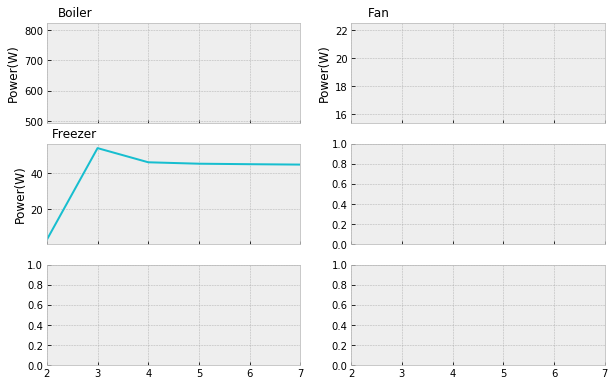

In [3]:
rcParams['figure.figsize'] = (10, 7)

fig, ((ax1, ax2),(ax3, ax4),(ax5, ax6)) = plt.subplots(3, 2, sharex=True,
                                                       gridspec_kw={'hspace': 0.2, 'wspace': 0.2})
#colores
colors=['tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:cyan']
m=2
for ax in fig.get_axes(): 
    next(train_elec[m].load(ac_type='active', sample_period=60,
                            resample_kwargs={'how':'first'})).plot(ax=ax, legend=False, color=colors[m-5])   
    ax.set_ylabel('Power(W)')
    ax1.set_ylim(auto=True)
    ax.minorticks_off()
    ax.set_xticklabels(labels=['2','3','4','5','6','7','8'], ha ='left')    
    ax.set_title(labels['Meters'][m-1], fontsize=12).set_position([.11, 1])
    c=['k','k','k','b','b','b','k','k']
    [t.set_color(i) for (i,t) in zip(c, ax.xaxis.get_ticklabels())]
    m=m+1

ax6.set_ylim(90,130)   
plt.savefig('./data/images/paso4/4.1_Plot_train.svg', bbox_inches='tight', transparent=True)
plt.show()
pass

### Modelos

#### CO

In [ ]:
from nilmtk.legacy.disaggregate import CombinatorialOptimisation
CO=CombinatorialOptimisation() #variable del modelo
CO.train(train_Devices) #entrenamiento del modelo CO


#### FHMM

In [ ]:
from nilmtk.legacy.disaggregate import FHMM
FHMM=FHMM() #variable del modelo
FHMM.train(train_Devices) #entrenamiento del modelo FHMM
FHMM


### Modelos CO y  Modelos FHMM  - MEAN y MEDIAN
Debido que los métodos mean y median realizan un cálculo sobre la señal original, solo tiene sentido entrenar modelos para periodos de muestreo diferentes al original de menos de 1 segundo. Por esto, para estos método solo se entrenarán modelos para los periodos 10s, 30s, 60s, 5min 
Periodos mayores como  10min, 15min y 30 min no son satifactorios con los datos de los qeu se dsiponen

In [16]:
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM

periods = {'1s':1, '10s':10 , '30s':30, '60s':60, '5min':60*5}
methods = ['first','mean', 'median']
dir_models = './data/NILM/Models/'

times = {} #almacena tiempos de ejecución
null= {} #diccionario nulo
    
for sp_name, sp in periods.items():
    t = []
    
    for method in methods:
        models={'CO':CombinatorialOptimisation(), 'FHMM':FHMM()}

        for model_name, model in models.items():
            print("*"*20 + ' ' + model_name + ' ' + sp_name+ ' ' + method + "*"*20)
            #Entrenamiento
            model.MIN_CHUNK_LENGTH = 1
            import time
            start = time.time()
            model.train(train_Devices,
                        num_states_dict={ }, #diccionario de estados nulo, por defecto
                        ac_type='active', #potencia activa, por defecto
                        sample_period=sp, #cambio de muestreo
                        resample_kwargs={'how':method}) #método

            t.append(round(time.time()-start,2)) #tiempo de simulación

            #Guarda modelo
            model_dir = dir_models + model_name + '_' + sp_name + '_' + method + '_model.pickle'
            #model.export_model(model_dir) 
            print(">>>>>>"+model_dir+"<<<<<<<<")

    times[sp_name] = t #tiempo de simulación

times_t2 = pd.DataFrame(times,index=['CO_first','FHMM_first','CO_mean', 'FHMM_mean', 'CO_median', 'FHMM_median'])
    
print('\n\nDone!')


******************** CO 1s first********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='boiler', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)])'
Training model for submeter 'ElecMeter(instance=7, building=1, dataset='DSUAL', appliances=[Appliance(type='light', instance=1)])'
Done training!
>>>>>>./data/NILM/Models/CO_1s_first_model.pickle<<<<<<<<
******************** FHMM 1s first********************
Training model for

Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)])'
Training model for submeter 'ElecMeter(instance=7, building=1, dataset='DSUAL', appliances=[Appliance(type='light', instance=1)])'
Done training!
>>>>>>./data/NILM/Models/CO_10s_mean_model.pickle<<<<<<<<
******************** FHMM 10s mean********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='boiler', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])' with 2 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])' with 3 states
Submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)])' has no samples, skipping...
Training model for s

Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])' with 1 states
Submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)])' has no samples, skipping...
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=7, building=1, dataset='DSUAL', appliances=[Appliance(type='light', instance=1)])' with 1 states
>>>>>>./data/NILM/Models/FHMM_30s_median_model.pickle<<<<<<<<
******************** CO 60s first********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='boiler', instance=1)])'
Training model for

Training model for submeter 'ElecMeter(instance=7, building=1, dataset='DSUAL', appliances=[Appliance(type='light', instance=1)])' with 1 states
>>>>>>./data/NILM/Models/FHMM_5min_first_model.pickle<<<<<<<<
******************** CO 5min mean********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='boiler', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)])'
Training model for submeter 'ElecMeter(instance=7, building=1, datase

In [17]:

#tiempos de simulación: entrenamiento
times_t2.transpose()

,CO_first,FHMM_first,CO_mean,FHMM_mean,CO_median,FHMM_median
1s,5.41,5.51,5.47,5.59,5.42,5.71
10s,4.81,4.48,4.74,4.48,4.74,4.50
30s,6.81,8.87,6.84,8.83,6.61,8.85
60s,6.63,8.74,6.85,8.78,6.89,9.01
5min,6.74,8.78,6.45,8.76,6.85,8.87
